# Projeto de Machine Learning - Automatização de empréstimos

## 1. Apresentação do projeto: 

### Apresentação:

Esse projeto tem como objetivo a criação de um mecânismo que incorpora as decisões de empréstimos de um companhia de forma automatizada, através de detalhes do solicitador, essa base de dados pode ser encontrada no site Kaggle, no link: https://www.kaggle.com/datasets/yashpaloswal/loan-prediction-with-3-problem-statement

### Entendimento do problema:

Uma companhia deseja automatizar seu processo de empréstimos, que são concedidos após avaliação de analistas que tem entendimento das regras de negócio. A automatização do processo pode gerar uma maior agilidade e otimização no ato do empréstimo, pois além de reduzir o tempo necessário para um empréstimo ser concedido, ela padroniza as decisões tomadas, resultados desejados em uma empresa que busca seu espaço no mercado. Através do Aprendizado de Máquina será possível criar um algorítimo que entende as regras de negócios implícitas nas decisões dos analistas, que serão aprendidas através da base de dados que contém os detalhes do solicitante do empréstimo e o resultado do pedido.

### Importando as bibliotecas:

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import optuna
import joblib

### Importando as classes e funções: 

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN

from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_auc_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer 

### Carregando a base de dados:

In [29]:
df = pd.read_csv(r"Loan Dataset\training_set.csv")

In [30]:
# A base de dados
display(df.head())

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,NaN,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y


## 2. Análise exploratória dos dados:

### Conhecendo os dados:

Conhecer os dados é uma parte muito importante do projeto, pois eles são a base de tudo que será contruído. O objetivo dessa etapa é ter o primeiro contato com a base de dados e identificar como o projeto seguirá daqui pra frente.

In [31]:
print(f"O dataframe tem {df.shape[0]} linhas e {df.shape[1]} colunas.")

O dataframe tem 614 linhas e 13 colunas.


A base de dados é bem pequena para os padrões comuns, podendo levar a resultados inferiores ou enviesados, porém permite muito mais flexibilidade ao projeto, pois será necessário menos capacidade computacional nos cálculos e manipulações. 

In [32]:
# Informações principais sobre a base de dados:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             599 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          613 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    612 non-null    float64
 7   CoapplicantIncome  613 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


A base de dados é dividida em colunas numéricas e categóricas, havendo uma predominância do segundo grupo. 

In [33]:
# Estatística descritiva das variáveis numéricas:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,612.000000,613.000000,592.000000,600.00000,564.000000
mean,5405.540850,1620.888940,146.412162,342.00000,0.842199
std,6118.914057,2928.624748,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2875.750000,0.000000,100.000000,360.00000,1.000000
50%,3806.000000,1167.000000,128.000000,360.00000,1.000000
75%,5803.750000,2302.000000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


 - **LoanAmount:** O tamanho do empréstimo é bem concetrado em torno da média, porém há grande disparidade no último quartil.
 - **CoapplicantIncome:** A renda do co-aplicante na média é muito menor e mais concentrada do que a do solicitante, apresentando os limites inferiores e superiores muito menores.
 - **ApplicantIncome:** A renda do solicitante é bastante volátil, marca de um média menor do que o desvio padrão, evidenciando uma grande dispersão dos dados, principalmente no último quartil que inicia em 5.803 e termina em 81.000.
 - **Credit_History:** O histórico de crédito tem uma média bem alta e próxima do seu limite, denotando uma grande concentração dos dados nessa faixa, ocupando 3 quartis com o mesmo valor.
 - **Loan_Amount_Term:** Os quartis indicam uma grande concentração de empréstimos com prazo de um ano, e no máximo de 1 ano e 4 meses.

In [34]:
# Valores nulos
valores_nulos = df.isna().mean()
lista_colunas = valores_nulos.index.to_list()

In [35]:
for coluna in lista_colunas:
    print(f"A coluna {coluna} tem {round(valores_nulos[coluna]*100, 2)}% de valores nulos")

A coluna Loan_ID tem 0.0% de valores nulos
A coluna Gender tem 2.44% de valores nulos
A coluna Married tem 0.49% de valores nulos
A coluna Dependents tem 2.44% de valores nulos
A coluna Education tem 0.16% de valores nulos
A coluna Self_Employed tem 5.21% de valores nulos
A coluna ApplicantIncome tem 0.33% de valores nulos
A coluna CoapplicantIncome tem 0.16% de valores nulos
A coluna LoanAmount tem 3.58% de valores nulos
A coluna Loan_Amount_Term tem 2.28% de valores nulos
A coluna Credit_History tem 8.14% de valores nulos
A coluna property_Area tem 0.0% de valores nulos
A coluna Loan_Status tem 0.0% de valores nulos


A base de dados apresenta uma pequena porcentagem de valores nulos, que serão tratados na etapa 3 do projeto.

In [36]:
# Porcentagem da variável dependente:
df.Loan_Status.value_counts()/len(df)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

Essa é a porcentagem de valores da variável **"Loan_Status"**, que é a variável dependente, no caso a que contém a resposta dos analistas aos pedidos de empréstimo. É possível perceber um desequilíbrio entre as classes, havendo muito mais dados de empréstimos aceitos do que negados, problema que pode levar a um enviesamento do modelo, que deve ser adereçado posteriormente.

### Visualização das variáveis:

- **Loan_ID** --> Identificação única para cada pedido de empréstimo.
- **Gender** --> Genêro do solicitante.
- **Married** --> O estado cívil do solicitante.
- **Dependents** --> A quantidade de pessoas dependentes do solicitante na família dele.
- **Education** --> O nível do educação do solicitante.
- **Self_Employed** --> Se o solicitante é empregado ou dono do próprio negócio.
- **ApplicantIncome** --> A renda do solicitante registrada
- **CoapplicantIncome** --> A renda do co-solicitante.
- **LoanAmount** --> A quantidade pedida no empréstimo.
- **Loan_Amount_Term** --> O tempo no qual o solicitante deseja pagar o empréstimo.
- **Credit_History** --> Se o solicitante tem um bom histórico de crédito ou não.
- **Property_Area** --> O tipo de propriedade que o solicitante ofereceu como hipóteca. Proxy do valor do imóvel.

Acima está uma descrição das variáveis que irá facilitar o entendimento das análises a seguir. Todas as variáveis menos **"Loan_ID"** serão analisadas, pois serão incluídas no modelo de classificação.

In [37]:
# Codificando a variável dependente:
df["Loan_Status"] = np.where(df["Loan_Status"] == "Y", 1, 0)

#### Correlações:

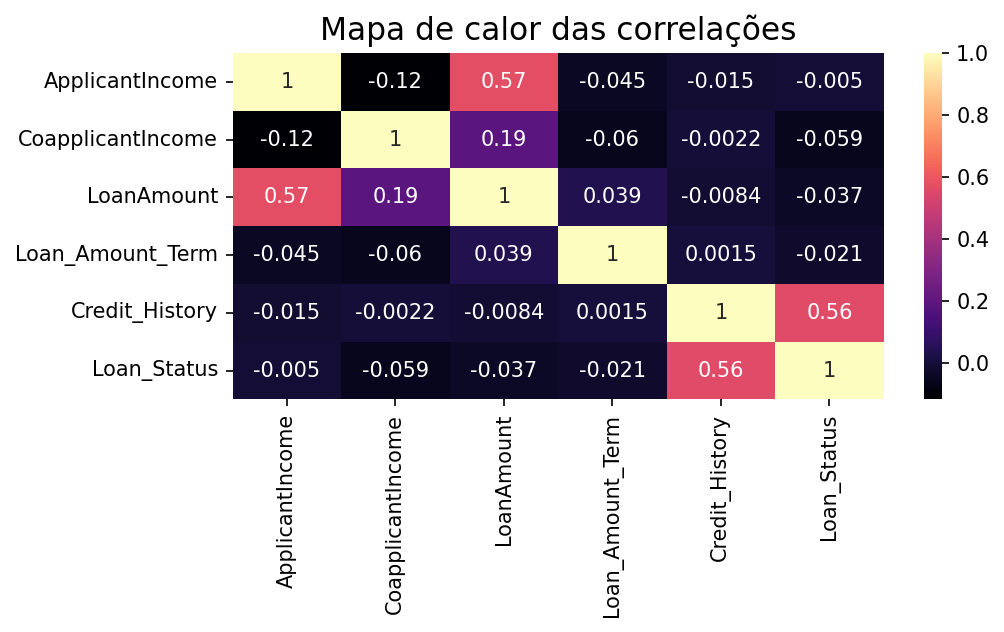

In [38]:
plt.figure(figsize=(7, 3), dpi=150)
plt.title("Mapa de calor das correlações", fontsize=15)
sns.heatmap(df.corr(),
            annot=True,
            cmap="magma");

No mapa correlacional é possível notar três informações interessantes: 
- A correlação entre **"Loan_Status"** e **"Credit_History"**, que denota uma grande importância do histórico de crédito no momento da aceitação da solicitação de empréstimo; 
- A relação entre **"Loan_Amount"**  e **"ApplicantIncome"**, que transmite a ideia de que quanto maior a renda maior a quantidade pedida em empréstimo;
- A pequena correlação entre **"CoapplicantIncome"**  e **"Loan_Amount"**, representa a pequena contribuição do co-aplicante na solicitação do empréstimo.

#### Estimativas de densidade kernel:

In [39]:
# Separando as colunas numéricas:
n_cols = ["CoapplicantIncome", "ApplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]

# Selecionando cores para os gráficos:
cores = ["#957DAD", "#A2DEBD", "#8384DF", "#F9AFEC", "#F9AFEC"]

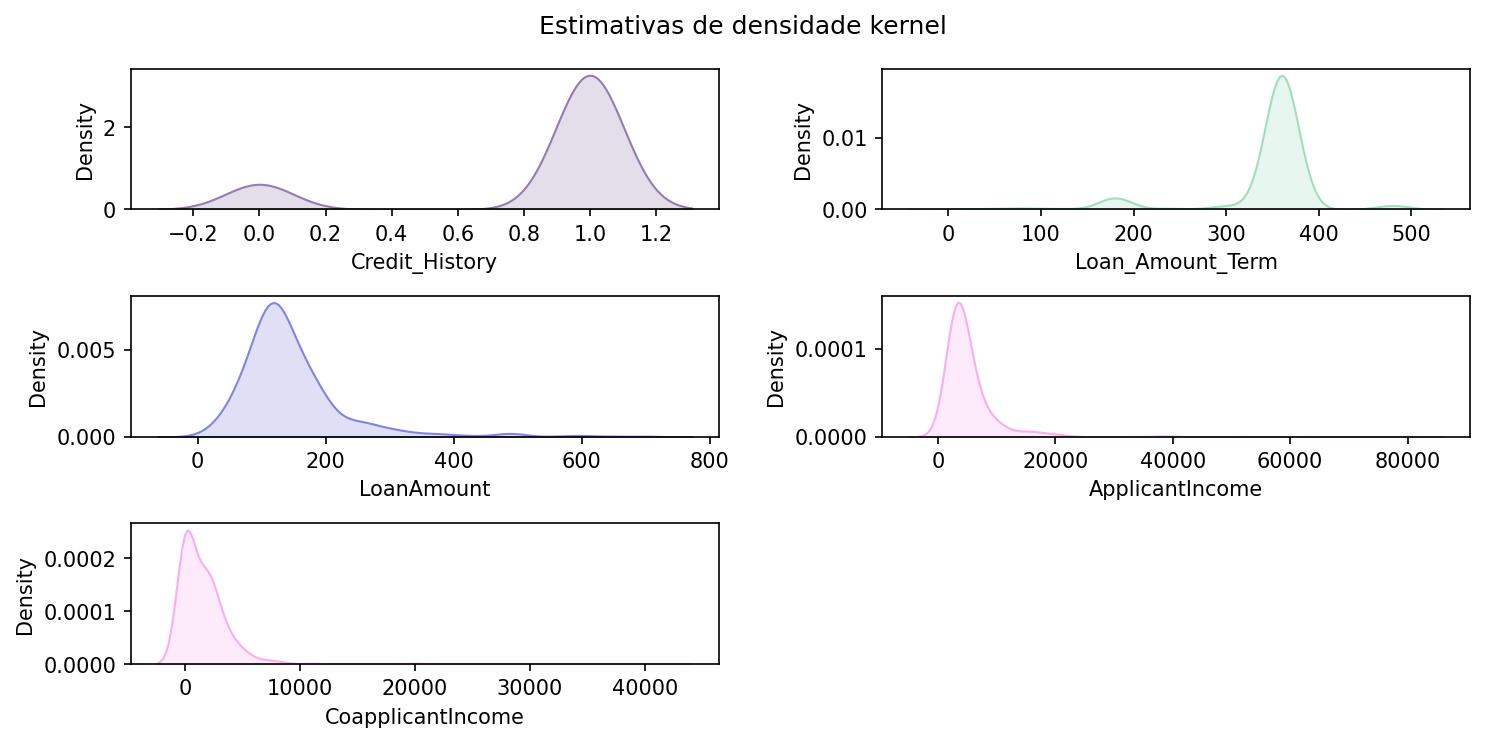

In [40]:
plt.figure(figsize=(10, 5), dpi=150)
plt.suptitle("Estimativas de densidade kernel")
for index, cor in zip(range(1,6), cores):
    plt.subplot(3, 2, index)
    sns.kdeplot(data=df,
                x=n_cols[-index],
                color=cor,
                fill=True)
plt.tight_layout()
plt.show()

 - **LoanAmount:** Tem uma densidade semelhante a distribuição t-student, porém com a margem direita se estendendo, indicando que apesar da grande concetração em torno de um valor, há outliers.
 - **CoapplicantIncome:** A renda dos co-aplicantes tem grande concentração no intervalo de 0 a 10.000, e principalmente na primeira metade desse intervalo.
 - **ApplicantIncome:** A renda dos aplicantes é bem concentrada também, porém se encontra em um intervalo um maior do que o dos co-aplicantes, indo de 0 a 20.000.
 - **Credit_History:** Em sua grande maioria perto de 1, representando um bom histórico de crédito, e uma minoria em torno de 0, representando um histórico inexistente ou muito ruim.
 - **Loan_Amount_Term:** É notável a grande densidade em torno de 360, que representa um empréstimo com pagamento de um ano, sendo esse o termo de pagamento mais comum, porém ainda há densidades expressivas em outros termos, como pagamentos de meio ano em torno de 180.

#### Diagramas de caixa:

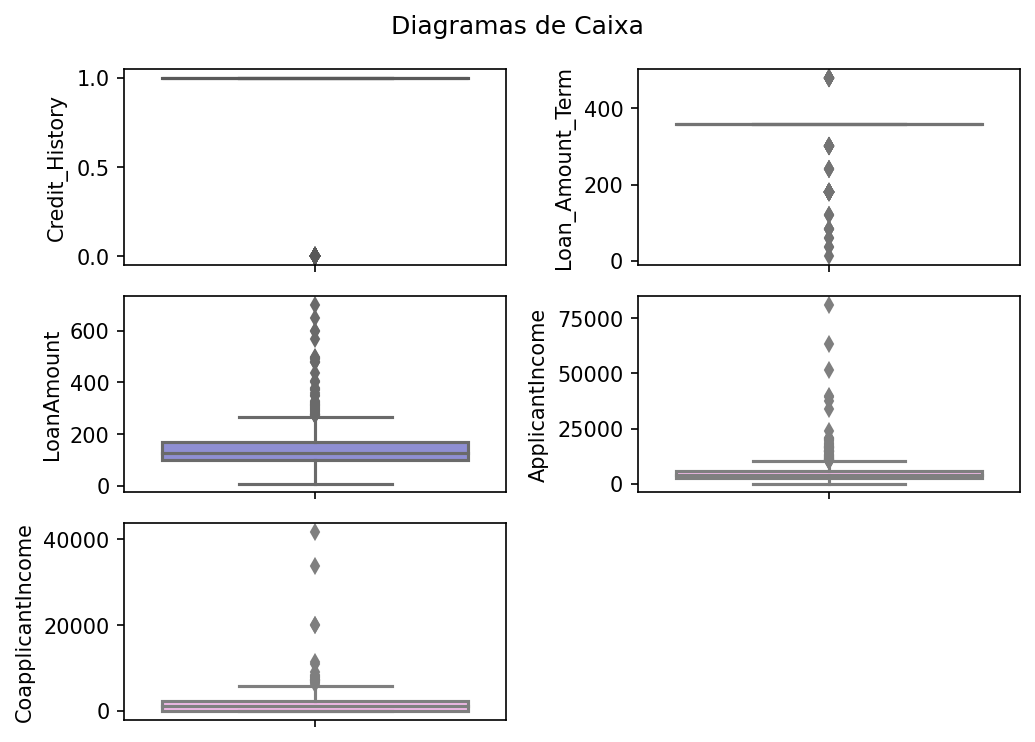

In [41]:
plt.figure(figsize=(7, 5), dpi=150)
plt.suptitle("Diagramas de Caixa")
for index, cor in zip(range(1,6), cores):
    plt.subplot(3, 2, index)
    sns.boxplot(data=df,
                y=n_cols[-index],
                color=cor)
plt.tight_layout()
plt.show()

Os diagramas de caixa reafirmam os resultados obtidos pelas estimativas de densidade de kernel, todas as variáveis são extremamente concentradas em torno de pequenos intervalos, e por conseguinte os valores fora desse intervalo são bastante discrepantes.

#### Gráficos de barra:

In [42]:
# Separando as colunas categoricas:
cat_cols = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "property_Area"]

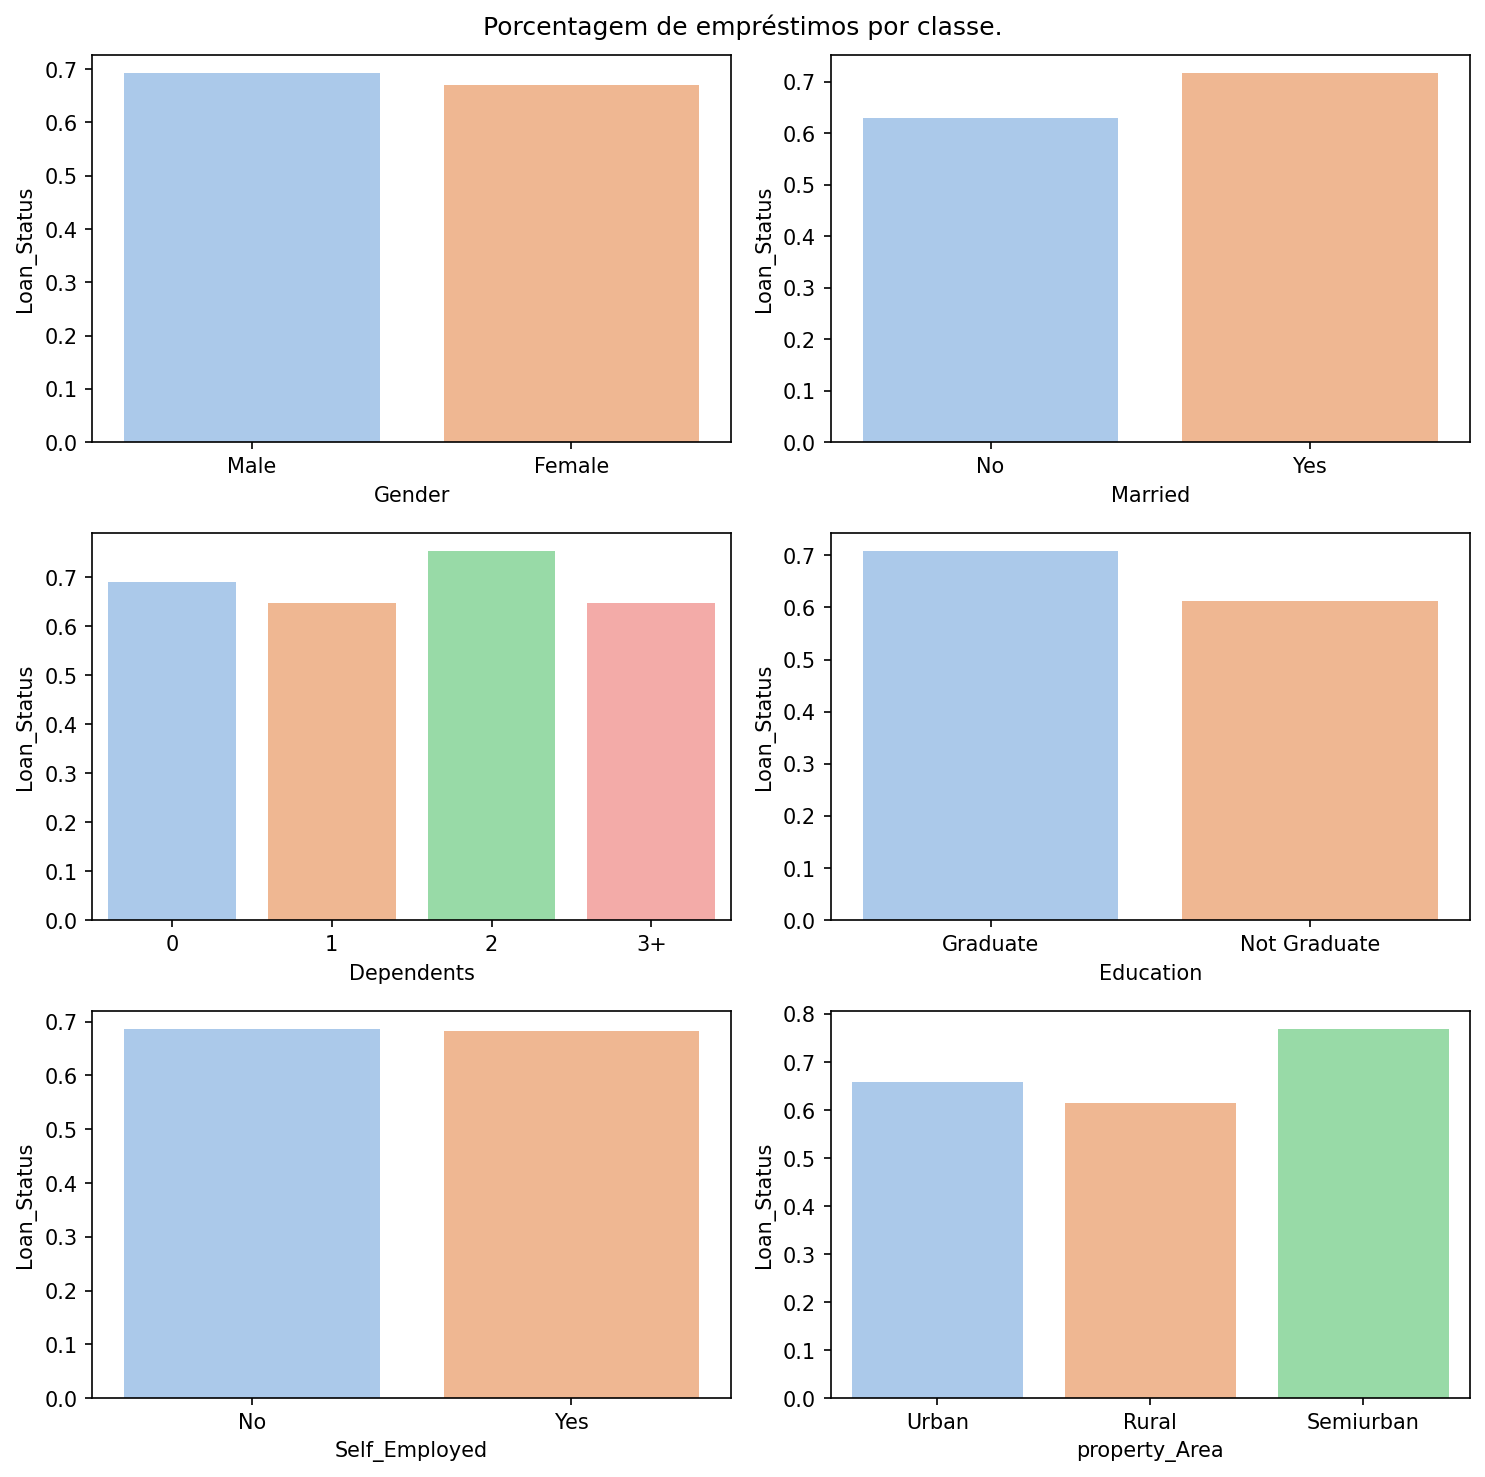

In [43]:
plt.figure(figsize=(10, 10), dpi=150)
plt.suptitle("Porcentagem de empréstimos por classe.")
for index, col in zip(range(1,7), cat_cols):
    plt.subplot(3, 2, index)
    sns.barplot(data=df,
                y="Loan_Status",
                x=col,
                palette="pastel",
                errorbar=None)
plt.tight_layout()
plt.show()

- **Gender:** Há uma probabilidade ligeiramente maior do empréstimo ser aceito se o genêro do solicitante for masculino.
- **Self_Employed:** Apesar da grande semelhança, pessoas donas do próprio negócio tem a probabilidade ligeiramente maior de receber o empréstimo.
- **property_Area:** Dentre os imóveis hipotecados, os na área semi-urbana apresentam uma maior probabilidade de aceitação de empréstimo, seguido por imóveis em área urbana.
- **Education:** Claramente pessoas com uma graduação tem vantagem sobre pessoas sem, no tocante a concessão do empréstimo.
- **Dependents:** Pessoas com 2 dependentes tem maior porcentagem de aceitação de empréstimo, seguido de pessoas sem dependentes.
- **Married:** É evidente que pessoas casadas tem uma maior chance de receber o empréstimo.

## 3. Feature Engineering:

### Preenchendo os dados faltando:

In [44]:
# Imputação dos dados faltando:
imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols + n_cols] = imputer.fit_transform(df[cat_cols + n_cols])

In [45]:
# Porcentagem de dados faltando:
df.isna().sum()/len(df)

Loan_ID              0.0
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
property_Area        0.0
Loan_Status          0.0
dtype: float64

Todos os dados faltando foram imputados usando a moda como substituição, a decisão foi baseada no fato de existirem muitos outliers na base de dados, prejudicando medidas como a média, e a moda poderia ser aplicada a base de dados inteira, servindo tanto para as variáveis numéricas quanto para as categoricas.

### Escalando os dados numéricos:

In [46]:
# Escalando os dados numéricos:
scaler = StandardScaler()
df[n_cols] = scaler.fit_transform(df[n_cols])

In [47]:
# Resultados:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,614.000000
mean,-4.769077e-17,9.474868e-17,-4.294429e-17,1.795524e-16,8.317632e-17,0.687296
std,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,0.463973
min,-8.591404e-01,-5.533267e-01,-1.622422e+00,-5.132498e+00,-2.428760e+00,0.000000
25%,-4.131178e-01,-5.533267e-01,-5.375641e-01,2.732313e-01,4.117327e-01,0.000000
50%,-2.634337e-01,-1.604500e-01,-2.433149e-01,2.732313e-01,4.117327e-01,1.000000
75%,6.533097e-02,2.321703e-01,2.292671e-01,2.732313e-01,4.117327e-01,1.000000
max,1.238152e+01,1.369384e+01,6.592777e+00,2.137276e+00,4.117327e-01,1.000000


Todas as variáveis numéricas foram devidamente escaladas agora. Esse processo auxilia a ingestão dos dados pelo modelo.

### Codificando as variáveis categóricas:

In [48]:
encoder = OneHotEncoder(sparse=False).fit(df[cat_cols])
novas_colunas = list(encoder.get_feature_names_out())
df[novas_colunas] = encoder.transform(df[cat_cols])

In [49]:
# Retirando as colunas agora inutéis:
df = df.drop(columns=cat_cols)
df = df.drop(columns="Loan_ID")

In [50]:
# Resultado final das transformações:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,property_Area_Rural,property_Area_Semiurban,property_Area_Urban
0,0.074174,-0.553327,-0.302759,0.273231,0.411733,1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.474285,-0.037697,-0.207648,0.273231,0.411733,0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.392401,-0.553327,-0.944757,0.273231,0.411733,1,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.460692,0.252942,-0.302759,0.273231,0.411733,1,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.098903,-0.553327,-0.053093,0.273231,0.411733,1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


Com a codificação das features categóricas o processo de transformação está terminado, O uso do OneHotEncoder em variáveis binárias é desnecessário, porém como a base de dados é pequena, a diferença no gasto computacional é irrelevante. A codificação acaba também por gerar multi-colinearidade na base de dados, o que é um problema para alguns modelos, porém serão usados modelos com regularização ou insensibilidade a multi-colinearidade. 

## 4. Modelagem:

### Metodologia:

Nessa etapa do projeto serão construídos diversos classificadores, de modo a encontrar o que melhor se aplica ao problema. As métricas usadas para definir a qualidade dos modelos será o  f1 score, que equilibra recall e precision, e também a matrix de confusão de cada modelo, principalmente a segunda. Mas antes do ínicio da modelagem serão feitos alguns experimentos, será aplicado um método de redução de dimensionalidade para analisar a separação dos dados e um para para equilibrar a proporção de classes na variável dependente.

In [51]:
# Separando a base de dados em conjuntos de treinamento e validação:
y = df["Loan_Status"]
train_df = df.drop(columns="Loan_Status")

X_train, X_val, y_train, y_val = train_test_split(train_df, y)

### Analisando a separação dos dados:

In [57]:
pca = PCA().fit(train_df)
componentes = pca.transform(train_df)

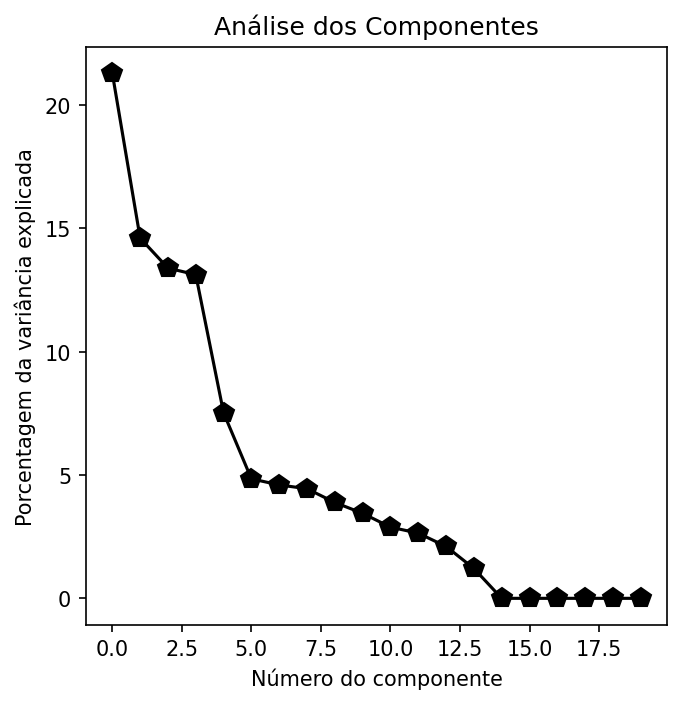

In [59]:
expl_var = pca.explained_variance_
expl_var = 100 * expl_var / sum(expl_var)

plt.figure(figsize=(5, 5), dpi=150)
plt.plot(expl_var, 'kp-', markerfacecolor='k', markersize=10)
plt.title("Análise dos Componentes")
plt.xlabel('Número do componente')
plt.ylabel('Porcentagem da variância explicada')
plt.show()

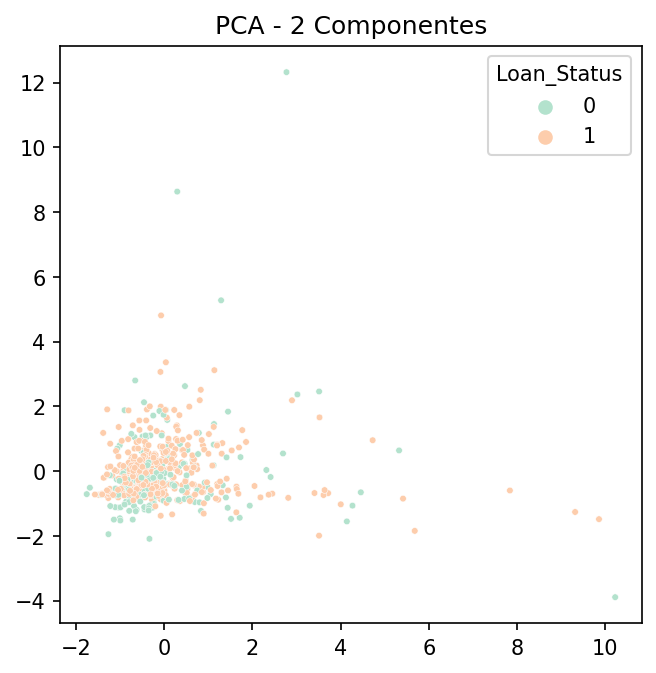

In [64]:
plt.figure(figsize=(5, 5), dpi=150)
sns.scatterplot(x=componentes[:,0],
                y=componentes[:,1],
                hue=y,
                palette="Pastel2",
                s=10)
plt.title("PCA - 2 Componentes")
plt.show()

É possível perceber que os dados não são linearmente separáveis, o que indica uma perda de desempenho nos modelos lineares.

### Regressão Logística - O modelo de parâmetro:

In [132]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
log_preds = log_reg.predict(X_val)

In [238]:
log_score = cross_val_score(log_reg, X_val, y_val, scoring=make_scorer(f1_score, pos_label=0)).mean()
print(f"O f1 score do modelo de regressão logística é de {round(log_score, 2) *100}%")

O f1 score do modelo de regressão logística é de 62.0%


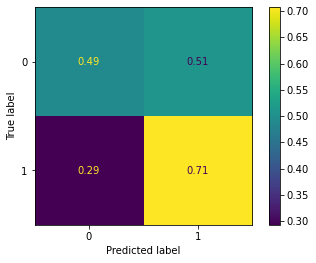

In [239]:
confusion_matrix_log = confusion_matrix(y_val, log_preds)
cf_display_log = ConfusionMatrixDisplay(confusion_matrix_log).from_estimator(log_reg,
                                                                             X_val, y_val,
                                                                             normalize="true")

A matrix de confusão nos mostra com mais detalhes as previsões feitas, e é possível perceber que quando o empréstimo é feito há uma mediana taxa de acerto, porém quando ele é negado há uma grande quantidade de erros de classificação, então nos deparamos com um problema de falso positivo, algo muito indesejado.

#### Transformando o processo em função:

In [152]:
def resultados_do_modelo(estimador, x, y):
    '''
    estimador: Um modelo padrão sklearn.
    x: input do modelo.
    y: target.
        return: f1_score e matrix de confusão.
    '''
    estimador.fit(x, y)
    preds = estimador.predict(x)
    score = cross_val_score(estimador, 
                            X_val, 
                            y_val, 
                            scoring=make_scorer(f1_score, pos_label=0)).mean()
    print(f"O f1 score do modelo é de {round(score, 2)*100}")
    conf_matrix = confusion_matrix(y, preds)
    display_matrix = ConfusionMatrixDisplay(conf_matrix).from_estimator(estimador,
                                                                        X_val, 
                                                                        y_val, 
                                                                        normalize="true")

### Usando a biblioteca Imbalanced-Learn:

In [241]:
# Criando dados para simular empréstimos negados:
resampler = SMOTEENN(sampling_strategy="minority", random_state=42)
X_re, y_re = resampler.fit_resample(X_train, y_train)

In [155]:
y_re.value_counts()

1    304
0    304
Name: Loan_Status, dtype: int64

Agora as classes estão equilibradas, iremos treinar novamente o modelo agora e observar os resultados.

O f1 score do modelo é de 62.0


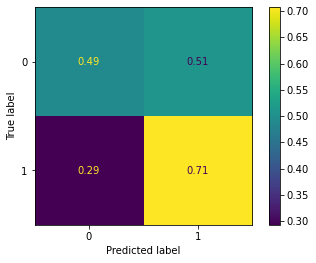

In [242]:
resultados_do_modelo(log_reg, X_re, y_re)

O f1 score continua o mesmo, e o resto das previsões ainda parece muito semelhante, porém isso se tratando do conjunto de validação, o modelo está tendo dificuldade de extrapolar.

In [243]:
log_reg_balanceado = LogisticRegression(random_state=42,
                                        class_weight={1:1, 0:2})

O f1 score do modelo é de 57.99999999999999


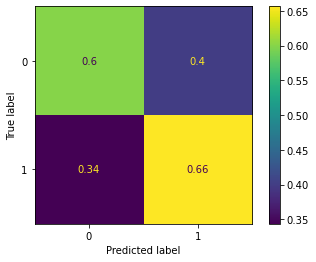

In [244]:
resultados_do_modelo(new_model, X_re, y_re)

Com esse ajuste nos pesos das classes, o modelo enfim performa de modo semelhante ao desejado, reduzindo ao máximo falsos positivos, e apresentando um desempenho mediano em geral na classificação dos empréstimos.

In [189]:
reg_coefs = pd.DataFrame(log_reg.coef_.T, 
                         index=log_reg.feature_names_in_, 
                         columns=["Coeficiente"]).sort_values("Coeficiente", ascending=False)

In [190]:
display(reg_coefs.head(5),
        reg_coefs.tail(5))

,Coeficiente
Credit_History,2.507093
property_Area_Semiurban,0.899934
Education_Graduate,0.719788
Dependents_2,0.705131
Married_Yes,0.543455


,Coeficiente
Loan_Amount_Term,-0.672553
Dependents_1,-0.709582
Education_Not Graduate,-0.719822
property_Area_Rural,-0.786807
LoanAmount,-1.567470


Acima constam as features com maior importância para os resultados do modelo. Entre as features mais importantes para a aceitação do empréstimo, estão o histórico de crédito, uma propriedade na área semi-urbana como hipoteca, graduação completa, possuir 2 dependentes e ser casado; informações constatadas anteriormente durante a análise dos dados. Já no lado contrário, os fatores mais impactantes em uma recusa de empréstimo são, o tamanho do empréstimo, usar uma propriedade rural como hipoteca, não possuir uma graduação, possuir apenas um dependente e o tempo de pagamento do empréstimo. As informações novas vêm principalmente da análise oposta à feita anteriormente, como o grande efeito da quantidade do empréstimo e o do intervalo de pagamento do empréstimo na negativa do empréstimo. 

#### Transformando o processo em função:

In [300]:
def visualizar_features_importantes(estimador, feature_array, features):
    '''
    estimador: Um modelo padrão sklearn.
    feature_array: A matrix com os coeficientes ou outras métricas de importância.
    features: As features
        return: dataframe com as informações organizadas.
    '''
    features_df = pd.DataFrame(feature_array.T,
                               index=list(features),
                               columns=["Importância"]).sort_values("Importância", ascending=False)
    display(features_df)

### K-ésimo Vizinho mais Próximo:

In [235]:
knn = KNeighborsClassifier(n_neighbors=3)

O f1 score do modelo é de 65.0


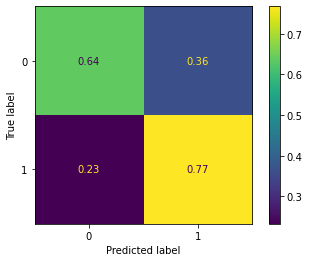

In [245]:
resultados_do_modelo(knn, X_re, y_re)

O modelo performou de forma superior a regressão logística, em ambas as classes.

### Floresta Aleatória:

In [284]:
random_forest = RandomForestClassifier(random_state=42)

O f1 score do modelo é de 59.0


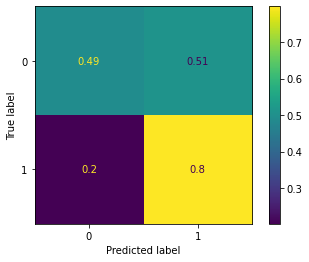

In [285]:
resultados_do_modelo(random_forest, X_re, y_re)

O modelo apresentou uma performance decepcionante após a evolução posterior, porém o modelo de Floresta Aleatória é muito sensível a mudança nos seus parâmetros, portanto ele será mais bem trabalhado a seguir:

In [ ]:
random_forest = RandomForestClassifier(random_state=42)

In [259]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 1000)
    min_samples_split = trial.suggest_float("min_samples_split", 0, 1)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 1, 1000)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", 1])
    
    classificador = RandomForestClassifier(n_jobs=-1,
                                           random_state=42,
                                           n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           min_samples_split=min_samples_split,
                                           min_samples_leaf=min_samples_leaf,
                                           max_leaf_nodes=max_leaf_nodes,
                                           max_features=max_features
                                           )
    classificador.fit(X_re, y_re)
    preds = classificador.predict(X_val)
    score = roc_auc_score(y_val, preds)
    return score

In [ ]:
optimizer = optuna.create_study(direction="maximize")
optimizer.optimize(objective, n_trials=100)

In [261]:
optimizer.best_params

{'n_estimators': 399,
 'max_depth': 466,
 'min_samples_split': 0.4772874199663032,
 'min_samples_leaf': 66,
 'max_leaf_nodes': 764,
 'max_features': 'log2'}

In [262]:
floresta_otimizada = RandomForestClassifier(random_state=42,
                                            **optimizer.best_params)

O f1 score do modelo é de 0.0


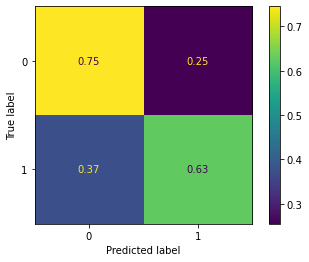

In [265]:
resultados_do_modelo(floresta_otimizada, X_re, y_re)

Agora temos uma melhora expressiva do modelo, que conseguiu diminuir bastante o número de falsos positivos, se aproximando bastante do modelo desejado, porém em troca de uma perda na classificação dos empréstimos. Apesar de em ambas as classes, o modelo já é superior a aleatoriedade.

In [301]:
visualizar_features_importantes(floresta_otimizada, floresta_otimizada.feature_importances_, floresta_otimizada.feature_names_in_)

,Importância
Credit_History,0.198433
property_Area_Rural,0.148825
property_Area_Semiurban,0.143603
Married_No,0.125326
Married_Yes,0.109661
LoanAmount,0.096606
CoapplicantIncome,0.060987
property_Area_Urban,0.046997
ApplicantIncome,0.036554
Dependents_0,0.033007


As features com maior importância no modelo são as comentadas anteriormente, com apenas algumas diferenças.

### ADA:

In [278]:
ada_boost = AdaBoostClassifier(random_state=42)

O f1 score do modelo é de 51.0


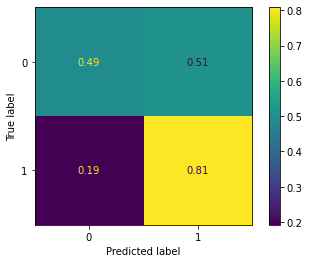

In [279]:
resultados_do_modelo(ada_boost, X_re, y_re)

O modelo de Ada Boost apresentou resultados um tanto decepecionantes, não havendo muito progresso, apesar desse modelo possuir a melhor classificação de verdadeiros positivos.

In [302]:
visualizar_features_importantes(ada_boost, ada_boost.feature_importances_, ada_boost.feature_names_in_)

,Importância
LoanAmount,0.28
ApplicantIncome,0.22
CoapplicantIncome,0.18
Dependents_0,0.08
Self_Employed_Yes,0.02
Loan_Amount_Term,0.02
Credit_History,0.02
property_Area_Semiurban,0.02
Gender_Male,0.02
Married_No,0.02


Por fim, nesse modelo houve uma grande diferença na importância das features, diferindo do encotrado anteriormente, talvez esse seja o motivo do resultado.

#### Escolha do modelo:

O modelo que será usado para a resolução do problema é o de Floresta Aleatória otimizado, pois apresentou a performance mais alinhada com o desejado.

In [288]:
# Salvando os objetos:
objetos = {"scaler":scaler, 
           "imputer":imputer,
           "encoder":encoder,
           "model":floresta_otimizada}
joblib.dump(objetos, "objetos.joblib")

['objetos.joblib']

## 5. Pipeline de dados: 

### Carregando os dados:

In [151]:
test_df = pd.read_csv(r"C:\Users\tm123\Downloads\Notebooks\Planilhas\Loan Dataset\testing_set.csv")
sample_df = pd.read_csv(r"C:\Users\tm123\Downloads\Notebooks\Planilhas\Loan Dataset\sample_submission.csv")
transformadores = joblib.load("objetos.joblib")

In [6]:
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [7]:
scaler = transformadores["scaler"]
modelo = transformadores["model"]
imputer = transformadores["imputer"]
encoder = transformadores["encoder"]

### Construção da pipeline:

In [198]:
def transformação(df, n_cols, cat_cols):
    df[n_cols + cat_cols] = imputer.fit_transform(df[n_cols + cat_cols])
    df[n_cols] = scaler.fit_transform(df[n_cols])
    novas_colunas = list(encoder.fit(df[cat_cols]).get_feature_names_out())
    df[novas_colunas] = encoder.transform(df[cat_cols])
    df = df.drop(columns=cat_cols)
    df = df.drop(columns="Loan_ID")
    return df

In [199]:
def previsão(df, n_cols, cat_cols):
    df = transformação(df, n_cols, cat_cols)
    preds = modelo.predict(df)
    return preds

In [200]:
# Separando as colunas:
cat_cols = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "property_Area"]
n_cols = ["CoapplicantIncome", "ApplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]

In [203]:
preds = previsão(test_df, n_cols, cat_cols)

C:\Users\tm123\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


As previsões finais do modelo já foram feitas e agora podemos avaliar o resultado do projeto.

## 6. Conclusão:

### Resultados do modelo:

In [208]:
y = sample_df["Loan_Status"]
y = np.where(sample_df["Loan_Status"] == "Y", 1, 0)

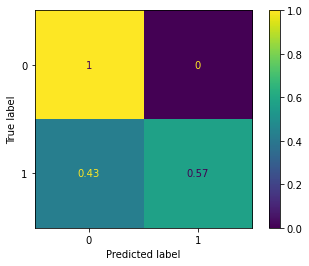

In [214]:
conf_matrix = confusion_matrix(y, preds, normalize="true")
display_matrix = ConfusionMatrixDisplay(conf_matrix).plot()

O modelo apresentou um resultado ainda melhor na classificação das negativas de empréstimo, já na classificação da aceitação dos empréstimos o resultado piorou, mal superando o palpite cego, porém é surpreendente o desempenho de 100% de eficiência contra os falsos positivos.

### Conclusão:

O objetivo do projeto era conseguir incorporar as regras de negócio por de trás das decisões de empréstimo, o objetivo foi apenas parcialmente atingido, pois há uma grande quantidade de falsos negativos, invertendo a situação inicial da modelagem. O projeto falhou em seu maior objetivo, porém durante o processo foi possível compreender diversas das regras de negócio através de análises e interpretações dos modelos, se aproximando de da mentalidade dos analistas que tomaram essas decisões anteriormente, muitas vezes não de forma teórica, mas sim intuitiva.